Demo NN using builtin datasets

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import time

start = time.time()

In [2]:
#download datasets locally
train = datasets.MNIST("", train = True, download = False,
                      transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train = False, download = False,
                      transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
#batches - don't want to give the algo all the data at once or it will not work as well on new data
#   usually best batch size is between 8 and 64
trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = True)
testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = True)

In [4]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [5]:
x, y = data[0][0], data[1][0]
print(y)

tensor(2)


In [6]:
print(data[0][0].shape)

#torch.Size([1, 28, 28])
#   size of image is actually an extra dimension
#   extra 1 dimension is 

torch.Size([1, 28, 28])


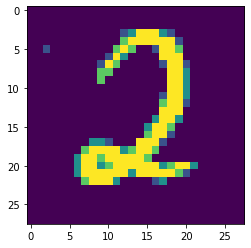

In [7]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0].view(28,28))

Balancing is SUPER important-
if 60% of our training data is a "3" then a set of weights that always guesses 3 will reach a local max and training will fail

In [8]:
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total += 1
        
print(counter_dict)


{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [9]:
for i in counter_dict:
    print(f"{i}: {counter_dict[i]/total*100}")

0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module): #create class Net and inherit from nn.Module
    def __init__(self):
        super().__init__() #need to run this because the init func of nn.Module is not run from inherit
       
        #Linear is a simple flat fuly connected
        self.fc1 = nn.Linear(784, 64) #when images are flattened they are 28*28 = 784 long
        self.fc2 = nn.Linear(64, 64)  #arbitrarily choosing 64 nodes for hidden layers
        self.fc3 = nn.Linear(64, 64) 
        self.fc4 = nn.Linear(64, 10)  #output layer is size 10 for digits 0-9
        
    def forward(self, x):
        #F.relu is rectified linear activation func
        #   activation func is sigmoid- keeps output from exploding
        #   attempt to model whether neuron is or is not firing
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #for output we only want one neuron to be fully fired
        x = self.fc4(x)
        
        return F.log_softmax(x, dim = 1) #since I am working with flat linear funcs this dim will always = 1
        
        
net = Net()
# print(net)

In [12]:
X = torch.rand((28,28)) #fake input image
X = X.view(-1,28*28)    #-1 specifies that input will be of unknown shape
output = net(X)
print(output) #

tensor([[-2.3301, -2.1851, -2.3650, -2.2539, -2.3776, -2.3530, -2.1667, -2.4040,
         -2.2446, -2.3797]], grad_fn=<LogSoftmaxBackward>)


In [13]:
#loss is a measure of how wrong is our model
#   loss should trend downward over time
# Optimizer adjusts weights bit by bit over time (according to learning rate) to lower loss

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001) #net.parmeters controls what stuff in net() is adjusted (default is everything)

#decaying learning rate -> lr decreases over time to prevent overshooting

EPOCHS = 3 #full passes through dataset

for epoch in range(EPOCHS):
    for data in trainset:
        #data is a batch of featuresets and labels
        X, y = data
        net.zero_grad()
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output, y) #usually use mean^2 error if data is onehot vector
        
        #magic backpropogation algorithm
        loss.backward()
        
        #adjusts weights
        optimizer.step()
        
    print (loss)
                
        

tensor(0.0372, grad_fn=<NllLossBackward>)
tensor(0.0152, grad_fn=<NllLossBackward>)
tensor(0.0185, grad_fn=<NllLossBackward>)


In [14]:
correct = 0
total = 0

with torch.no_grad():
    #net.train() and net.eval() are depreciated ways of changing the mode
    for data in testset:
        X, y = data
        output = net(X.view(-1, 784))
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
                
            total += 1
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.971


In [15]:
finish = time.time()
print("training took ", finish-start, " seconds" )

training took  65.26460933685303  seconds
